In [3]:
!pip install textblob nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Abdul
[nltk_data]     rahim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from textblob import TextBlob
from sklearn.cluster import KMeans
from nltk.corpus import stopwords

def colored_text(text, color_code="34", bold=True):
    bold_code = "1;" if bold else ""
    return f"\033[{bold_code}{color_code}m{text}\033[0m"

file_path = r"C:\Users\Abdul rahim\Documents\spam_ham_dataset.csv"
data = pd.read_csv(file_path)
data = data[['label', 'text']]

def calculate_sender_reputation_score(email_text):
    domain_score_map = {'gmail.com': 10, 'yahoo.com': 5, 'hotmail.com': 5, 'unknown': 1}
    domain = re.search(r'@([\w.]+)', email_text)
    return domain_score_map.get(domain.group(1), 1) if domain else 1

data['sender_reputation_score'] = data['text'].apply(calculate_sender_reputation_score)

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char == ' '])
    return text

data['text'] = data['text'].apply(preprocess_text)

def sentiment_analysis(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive", "Contains promotional/encouraging terms"
    elif polarity < -0.1:
        return "Negative", "Suggests critical or negative tone"
    else:
        return "Neutral", "No strong emotion detected"

data['sentiment'], data['sentiment_reason'] = zip(*data['text'].apply(sentiment_analysis))

spam_keywords = ["free", "win", "credit", "urgent", "congratulations", "click", "link"]
def keyword_freq_analysis(text):
    matched_keywords = [keyword for keyword in spam_keywords if keyword in text]
    return len(matched_keywords), matched_keywords

data['keyword_freq'], data['keywords_found'] = zip(*data['text'].apply(keyword_freq_analysis))

data['text_length'] = data['text'].apply(len)

vectorizer = TfidfVectorizer(max_features=3000)
tfidf_matrix = vectorizer.fit_transform(data['text'])
spam_data = data[data['label'] == 'spam']
kmeans = KMeans(n_clusters=3, random_state=42)
spam_clusters = kmeans.fit_predict(tfidf_matrix[spam_data.index])

cluster_labels = {0: "Phishing", 1: "Promotion", 2: "Malware"}
data.loc[data['label'] == 'spam', 'spam_cluster'] = [cluster_labels.get(cluster, "Other") for cluster in spam_clusters]
data['spam_cluster'] = data['spam_cluster'].fillna("Not Spam")

X = tfidf_matrix.toarray()
additional_features = data[['sender_reputation_score', 'text_length', 'keyword_freq']].values
X = np.hstack([X, additional_features])

y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

def predict_spam():
    print("Enter 4 email messages and their senders:")
    messages = []
    senders = []
    
    for i in range(4):
        message_text = input(f"Enter message {i+1}: ")
        sender_email = input(f"Enter sender email for message {i+1}: ")
        messages.append(message_text)
        senders.append(sender_email)
        print()

    for i in range(4):
        message_text = messages[i]
        sender_email = senders[i]

        print(colored_text(f"\nPrediction for message {i+1}:", "33", bold=True))

        sender_reputation_score = calculate_sender_reputation_score(sender_email)

        processed_text = preprocess_text(message_text)
        sentiment, sentiment_reason = sentiment_analysis(processed_text)
        keyword_freq, keywords_found = keyword_freq_analysis(processed_text)
        text_length = len(processed_text)
        vectorized_text = vectorizer.transform([processed_text]).toarray()

        additional_features_pred = np.array([[sender_reputation_score, text_length, keyword_freq]])
        X_pred = np.hstack([vectorized_text, additional_features_pred])

        prediction = 'spam' if keyword_freq >= 1 else model.predict(X_pred)[0]

        if sender_reputation_score <= 3:
            print(colored_text("Prediction: Spam (based on sender's email domain)", '33'))
            prediction = 'spam'
        elif keyword_freq >= 1:
            print(colored_text("Prediction: Spam (based on spam keywords)", '33'))
            prediction = 'spam'
        else:
            print(colored_text("Prediction: Not Spam", '32'))

        print(colored_text("Sample message prediction:", "36"))
        print(f"Message: '{message_text}'")
        print(f"Prediction: {colored_text('Spam' if prediction == 'spam' else 'Not Spam', '33')}\n")

        print(colored_text("Sender Reputation Score (1-10):", "34"), sender_reputation_score)
        print()
        print(colored_text("Sentiment Analysis:", "34"))
        print(colored_text("Sentiment:", "34"), sentiment)
        print(colored_text("Sentiment Reason:", "34"), sentiment_reason, "\n")
        print(colored_text("Keyword Frequency:", "34"), keyword_freq)
        print(colored_text("Matched Keywords:", "34"), keywords_found, "\n")
        print(colored_text("Text Length:", "34"), text_length)

        if prediction == 'spam':
            predicted_cluster = kmeans.predict(vectorized_text)
            spam_category = cluster_labels.get(predicted_cluster[0], "Unknown")
            print(colored_text("Spam Category:", "34"), spam_category)

            y_true = 'spam' if prediction == 'spam' else 'ham'
            accuracy = accuracy_score([y_true], [prediction])
            precision = precision_score([y_true], [prediction], pos_label='spam', zero_division=1)
            recall = recall_score([y_true], [prediction], pos_label='spam', zero_division=1)
            f1 = f1_score([y_true], [prediction], pos_label='spam', zero_division=1)

            print("\n" + colored_text("Evaluation", "36"))
            print(f"Accuracy: {accuracy:.2%}")
            print(f"Precision: {precision:.2%}")
            print(f"Recall: {recall:.2%}")
            print(f"F1 Score: {f1:.2%}\n")

predict_spam()


Enter 4 email messages and their senders:


Enter message 1:  hi how are you
Enter sender email for message 1:  abdulrahim@gmail.com


Enter message 2:  we are call from accenture
Enter sender email for message 2:  accenturehr@gamil.com


Enter message 3:  win the free gift click the link 
Enter sender email for message 3:  adfvnnn.@yuhcom


Enter message 4:  you are under arrest cilck the link and done payment to release
Enter sender email for message 4:  cyberteam@maild.com




Prediction for message 1:
Prediction: Not Spam
Sample message prediction:
Message: 'hi how are you'
Prediction: Not Spam

Sender Reputation Score (1-10): 10

Sentiment Analysis:
Sentiment: Neutral
Sentiment Reason: No strong emotion detected 

Keyword Frequency: 0
Matched Keywords: [] 

Text Length: 14

Prediction for message 2:
Prediction: Spam (based on sender's email domain)
Sample message prediction:
Message: 'we are call from accenture'
Prediction: Spam

Sender Reputation Score (1-10): 1

Sentiment Analysis:
Sentiment: Neutral
Sentiment Reason: No strong emotion detected 

Keyword Frequency: 0
Matched Keywords: [] 

Text Length: 26
Spam Category: Malware

Evaluation
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


Prediction for message 3:
Prediction: Spam (based on sender's email domain)
Sample message prediction:
Message: 'win the free gift click the link '
Prediction: Spam

Sender Reputation Score (1-10): 1

Sentiment Analysis:
Sentiment: Positive
Sent

C:\Users\Abdul rahim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Abdul rahim\AppData\Local\Temp\ipykernel_24112\2169601657.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_data['spam_cluster'] = spam_clusters
C:\Users\Abdul rahim\AppData\Local\Temp\ipykernel_24112\2169601657.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

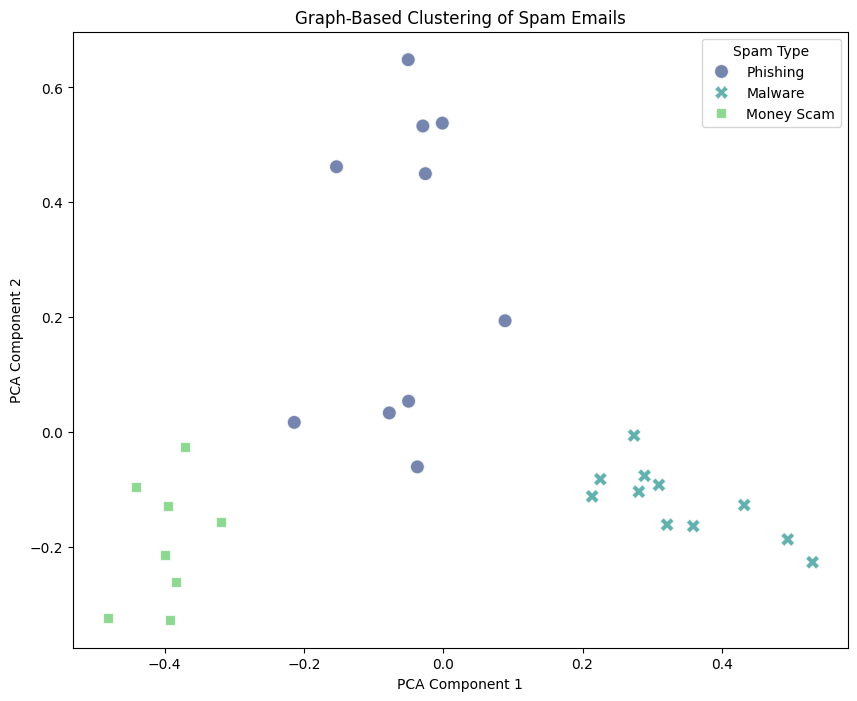

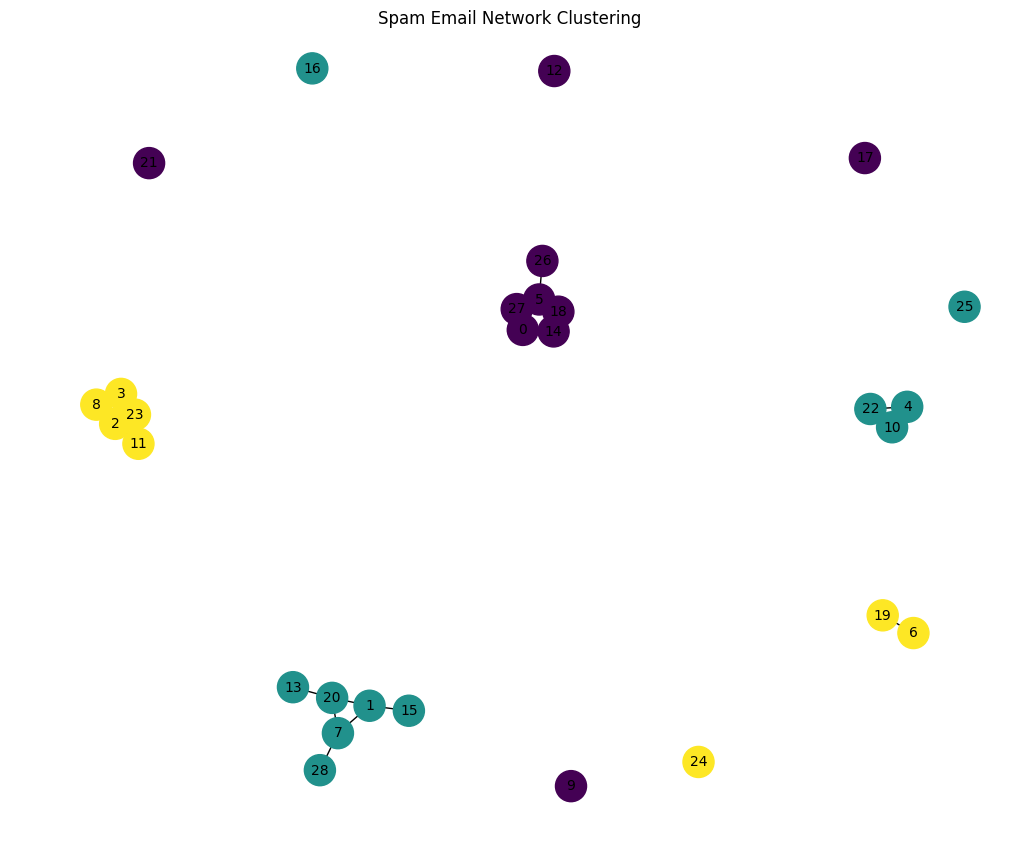

Email 1: congratulations you have won a free iphone click the link to claim your prize... -> Spam Type: Phishing
Email 3: urgent your account has been compromised please click here to verify your details... -> Spam Type: Malware
Email 5: claim your prize now limited offer dont miss out... -> Spam Type: Money Scam
Email 7: free money get cash now dont miss this exclusive offer... -> Spam Type: Money Scam
Email 9: malware detected on your computer click here to clean your system now... -> Spam Type: Malware
Email 12: congratulations youve won a free vacation click to claim your prize... -> Spam Type: Phishing
Email 14: free money get a 1000 gift card now limited time only... -> Spam Type: Money Scam
Email 16: urgent your bank account has been compromised click here to secure your account immediately... -> Spam Type: Malware
Email 18: claim your free iphone now offer expires soon dont miss out... -> Spam Type: Money Scam
Email 20: special offer win a brand new car enter now to be in the d

In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA

# Load dataset
file_path = r"C:\Users\Abdul rahim\OneDrive\Documents\email filtering ds.xlsx"
data = pd.read_excel(file_path)

# Preprocess the data (only the relevant columns for spam classification)
data = data[['label', 'text']]

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char == ' '])
    return text

# Apply text preprocessing
data['text'] = data['text'].apply(preprocess_text)

# Filter only spam emails
spam_data = data[data['label'] == 'spam']

# TF-IDF Vectorization for only spam emails
vectorizer = TfidfVectorizer(max_features=3000)
tfidf_matrix = vectorizer.fit_transform(spam_data['text'])

# Cosine Similarity Matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Apply Spectral Clustering for only spam emails
spectral_clustering = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
spam_clusters = spectral_clustering.fit_predict(cosine_sim)

# Add the cluster labels to the dataset
spam_data['spam_cluster'] = spam_clusters

# Map Cluster IDs to Spam Types (Phishing, Malware, Money Scam)
cluster_labels = {0: "Phishing", 1: "Malware", 2: "Money Scam"}
spam_data['spam_type'] = spam_data['spam_cluster'].map(cluster_labels)

# Visualize the clusters with PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Create a scatter plot with distinct cluster symbols and colors
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=spam_data['spam_type'], palette='viridis', s=100, alpha=0.7, style=spam_data['spam_type'])
plt.title("Graph-Based Clustering of Spam Emails")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Spam Type")
plt.show()

# For an interactive network visualization using NetworkX:
G = nx.Graph()

# Add nodes (emails) only from the spam data
for i in range(len(spam_data)):
    G.add_node(i, label=spam_data['label'].iloc[i], text=spam_data['text'].iloc[i])

# Add edges based on cosine similarity (threshold = 0.3 for example)
threshold = 0.3
for i in range(len(spam_data)):
    for j in range(i+1, len(spam_data)):
        if cosine_sim[i, j] > threshold:
            G.add_edge(i, j)

# Draw the network graph with different colors for each cluster
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
node_colors = [spam_clusters[i] for i in range(len(spam_data))]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, cmap=plt.cm.viridis, font_size=10)
plt.title("Spam Email Network Clustering")
plt.show()

# Print some sample spam emails with their predicted spam type
for idx, row in spam_data.head(10).iterrows():
    print(f"Email {idx+1}: {row['text'][:100]}... -> Spam Type: {row['spam_type']}")
